Imports

In [86]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

Retrieving bitcoin prices

In [87]:
df = yf.download('BTC-USD')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


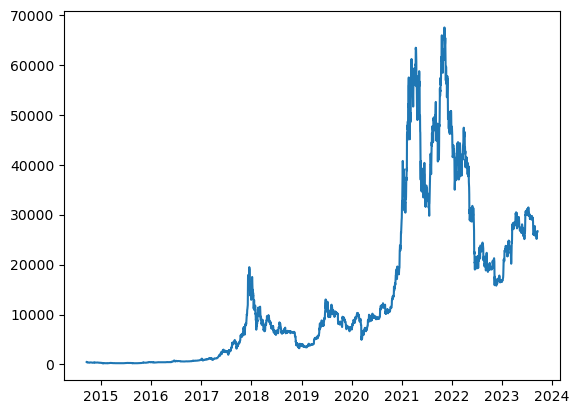

In [88]:
plt.plot(df.index, df['Adj Close'])
plt.show()

In [89]:
to_row = int(len(df) * 0.75)

training_data = list(df[0:to_row]['Adj Close'])
testing_data = list(df[to_row:]['Adj Close'])

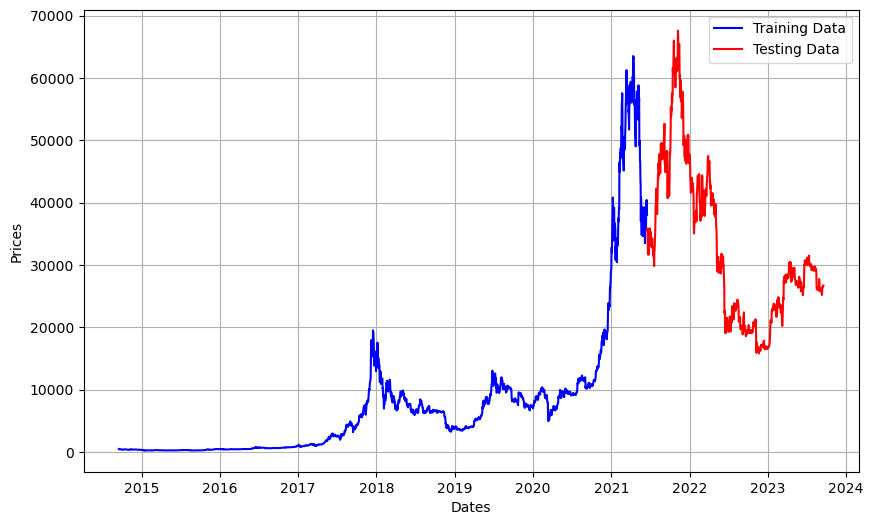

In [90]:
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.plot(df[0:to_row]['Adj Close'], 'blue', label='Training Data')
plt.plot(df[to_row:]['Adj Close'], 'red', label='Testing Data')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

plt.show()

Using ADF test to get p-values and check stationarity

In [91]:
result = sm.tsa.adfuller(df['Adj Close'])
adf = result[0]
pvalue = result[1]

print(f'ADF Statistic: {adf}')
print(f'p-value: {pvalue}')

ADF Statistic: -1.6173437136553868
p-value: 0.47412215902863686


Apply n order differencing to get a p-value < 0.001

In [92]:
df['Differenced'] = df['Adj Close'].diff(periods=1)

df.dropna(inplace=True)

result = sm.tsa.adfuller(df['Differenced'])
adf = result[0]
pvalue = result[1]

print(f'ADF Statistic: {adf}')
print(f'p-value: {pvalue}')

ADF Statistic: -9.609663419141924
p-value: 1.8260732041918016e-16


PACF and ACF

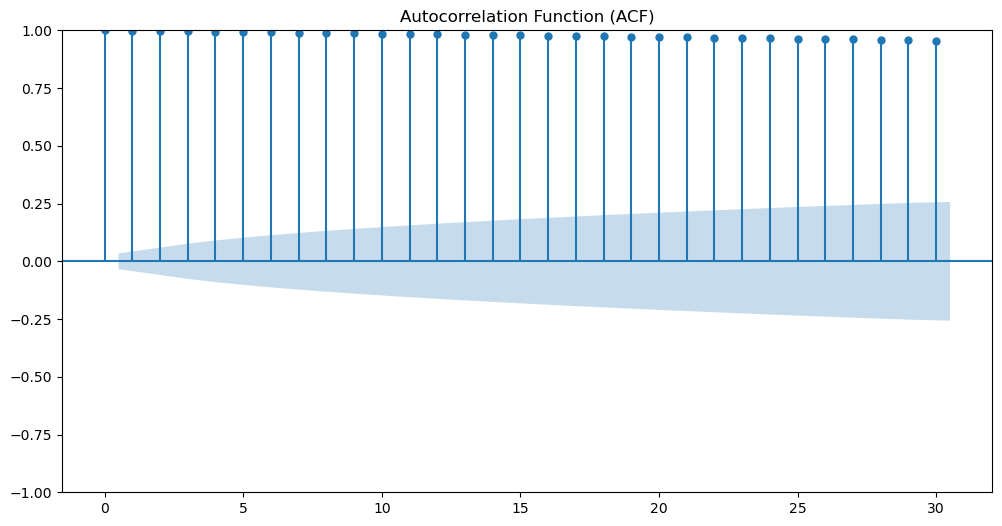

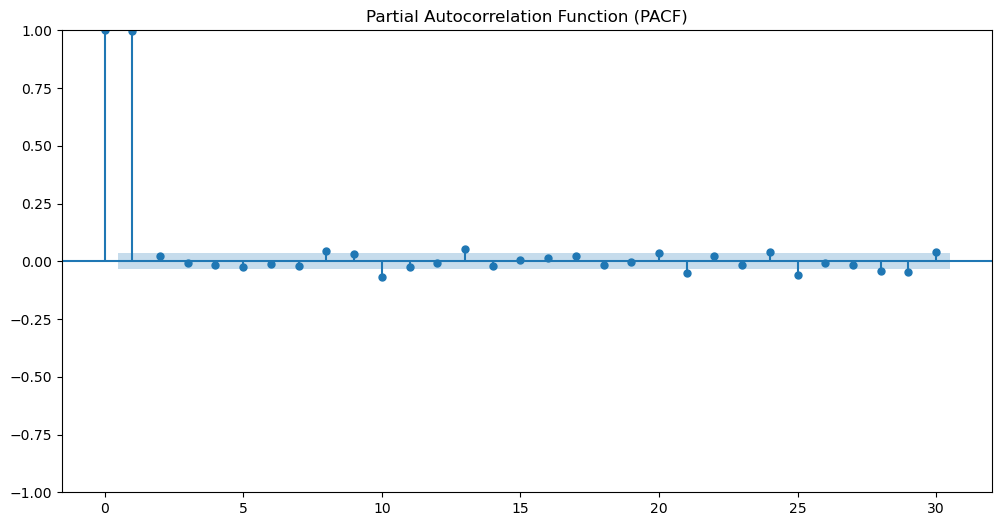

In [101]:
# ACF(q value)
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF(p value)
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The above indicates that the p value should be 2 and from the adf test we need that we only need 1 order of differencing. The ACF not dropping indicates there is a long memory or a long-range dependence in the time series data

Creating arima model to forecast and adding predictions to the observed past values

In [94]:
model_predictions = []
n_steps = len(testing_data)
for i in range(n_steps):
    model = sm.tsa.ARIMA(training_data, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

In [95]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3288
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -26555.176
Date:                Sun, 17 Sep 2023   AIC                          53116.351
Time:                        22:57:39   BIC                          53134.644
Sample:                             0   HQIC                         53122.901
                               - 3288                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0243      0.009     -2.689      0.007      -0.042      -0.007
ar.L2          0.0082      0.009      0.951      0.342      -0.009       0.025
sigma2      6.095e+05   4955.188    123.007      0.0

Plotting bitcoin price predictions

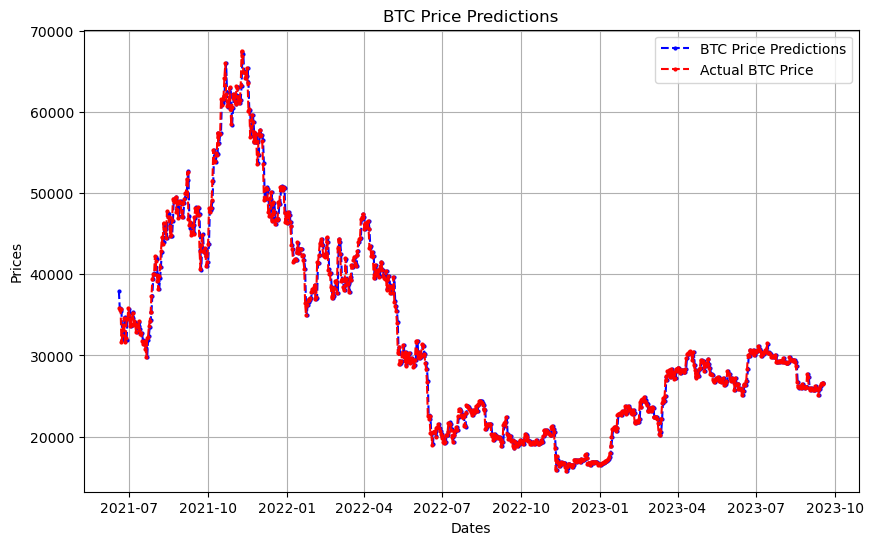

In [98]:
plt.figure(figsize=(10, 6))
plt.grid(True)

date_range = df[to_row:].index

plt.plot(date_range, model_predictions[:-1], color='blue', marker='o', markersize=2, linestyle='dashed', label='BTC Price Predictions')
plt.plot(date_range, testing_data[:-1], color='red', marker='o', markersize=2, linestyle='dashed', label='Actual BTC Price')

plt.title('BTC Price Predictions')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

plt.show()

Accuracy

In [106]:
mae = np.mean(np.abs(np.array(model_predictions) - np.array(testing_data)))
print(f'MAE: {mae}')
mse = np.mean((np.array(model_predictions) - np.array(testing_data)) ** 2)
print(f'MSE: {mse}')
rmse = math.sqrt(mse)
print(f'RMSE: {rmse}')

MAE: 723.2963838510751
MSE: 1252629.4701147296
RMSE: 1119.2093057666782
MAE Accuracy: 0.0013825591034696745
